In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('spam.csv', sep=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
import matplotlib.pyplot as plt
spam_count = df.groupby('v1').count()
plt.bar(spam_count.index.values, spam_count['v2'], tick_label = spam_count['v2'])
plt.xlabel('Spam Label')
plt.show()


<Figure size 640x480 with 1 Axes>

In [4]:
## Merging columns 2,3,4 to 1

def cmerge(ldf) :
    ldf =  ldf.copy()
    for i in range(len(ldf)):
        if not pd.isna(ldf.iloc[i,2]):
            ldf['v2'][i] = ldf['v2'][i] + ldf[ldf.columns[2]][i]
        if not pd.isna(ldf.iloc[i,3]):
            ldf['v2'][i] = ldf['v2'][i] + ldf[ldf.columns[3]][i]
        if not pd.isna(ldf.iloc[i,4]):
            ldf['v2'][i] = ldf['v2'][i] + ldf[ldf.columns[4]][i]
    ldf = ldf.iloc[:,0:2]
    ldf = ldf.rename(columns={"v1": "label", "v2": "text"})
    return ldf



In [5]:
df2 = cmerge(df)
df2.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
import re, nltk, string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet


stop_words = set(stopwords.words('english'))

wordnet_lemmatizer = WordNetLemmatizer()

def normalizer(text):
    text = "".join([word for word in text if word not in string.punctuation]) # m
    tokens = word_tokenize(text.lower())
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in tokens if t.isalpha()]
    filtered_result = list(filter(lambda l: l not in stop_words, lemmas))
    result = ' '.join(filtered_result)
    return result

In [7]:
df3 = df2.copy()
for i in range(len(df3)):
    df3['text'][i] = normalizer(df3['text'][i])

df3.head(10)

,label,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts may...
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though
5,spam,freemsg hey darling week word back id like fun...
6,ham,even brother like speak treat like aid patent
7,ham,per request melle melle oru minnaminunginte nu...
8,spam,winner valued network customer selected receiv...
9,spam,mobile month u r entitled update latest colour...


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

def feature_extraction(mode, df):
    df = df.copy()
    text = ''
    if mode == 1:
        text = CountVectorizer().fit_transform(df['text'])
    elif mode == 2 :
        text = TfidfVectorizer().fit_transform(df['text'])
        
    X_train, X_test, y_train, y_test = train_test_split(text, df['label'], test_size = 0.1, random_state = 1)
    X_train, y_train = RandomOverSampler(random_state=123).fit_resample(X_train, y_train)
    return X_train, X_test, y_train, y_test

Using TensorFlow backend.


In [9]:
data_countvectorizer = feature_extraction(1, df3)
data_tfidf = feature_extraction(2, df3)

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder


def model(X_train, X_test, y_train, y_test):    
    fpr = {}
    tpr = {}
    roc_auc = {}
    acc_score = {}
    le = LabelEncoder()
    y = le.fit_transform(y_test)
    clf = {
            'Multinomial Naive Bayes' : MultinomialNB(),
            'SVM' : SVC(gamma='scale'),
            'XGBoost' : XGBClassifier(nthread=4),
            'Logistic Regression' : LogisticRegression(solver='lbfgs'),
            'Random Forest' : RandomForestClassifier(n_estimators=10),
            'KNN' : KNeighborsClassifier(n_neighbors = 10),
            'Decision Tree' : DecisionTreeClassifier(),
            'AdaBoost' : AdaBoostClassifier(n_estimators=10, random_state=123),
          }
    for i in clf.keys():
        clf[i].fit(X_train, y_train)
        predicted = clf[i].predict(X_test)
        print('{} Accuracy : {}'.format(i,metrics.accuracy_score(y_test, predicted)))
        if i != 'SVM':
            fpr[i], tpr[i], _ = roc_curve(y, clf[i].predict_proba(X_test)[:,1])
        else :
            fpr[i], tpr[i], _ = roc_curve(y, le.transform(predicted))
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label='{} (area = {})'.format(i, roc_auc[i]))
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.show()

- Menggunakan Count Vectorizer -
Multinomial Naive Bayes Accuracy : 0.967741935483871
SVM Accuracy : 0.9838709677419355
XGBoost Accuracy : 0.9372759856630825
Logistic Regression Accuracy : 0.989247311827957
Random Forest Accuracy : 0.9838709677419355
KNN Accuracy : 0.9605734767025089
Decision Tree Accuracy : 0.9480286738351255
AdaBoost Accuracy : 0.8763440860215054


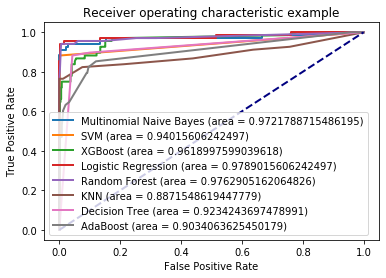


- Menggunakan TFIDF Vectorizer-
Multinomial Naive Bayes Accuracy : 0.9659498207885304
SVM Accuracy : 0.985663082437276
XGBoost Accuracy : 0.9265232974910395
Logistic Regression Accuracy : 0.982078853046595
Random Forest Accuracy : 0.9767025089605734
KNN Accuracy : 0.9139784946236559
Decision Tree Accuracy : 0.942652329749104
AdaBoost Accuracy : 0.8835125448028673


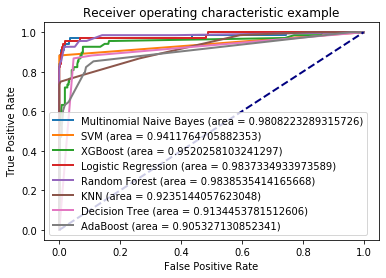

In [15]:
print("- Menggunakan Count Vectorizer -")
model(data_countvectorizer[0], data_countvectorizer[1], data_countvectorizer[2], data_countvectorizer[3])
print("\n- Menggunakan TFIDF Vectorizer-")
model(data_tfidf[0],data_tfidf[1],data_tfidf[2],data_tfidf[3])